# Predict Mortgage Applicant Default with Keras Tensor Flow

This notebook guides you through the basic concepts to construct a neural net model with the Keras library - a wrapper library for low level deep learning libraries such as Tensorflow. It includes instructions on how to import the predictive data, train the model to predict client behaviors, and save the model to your DSX Machine Learning to be used for model management and online scoring.

Some familiarity with Python is recommended. This notebook runs on Python 2 with Spark 2.


## Describe the business problem

Suppose a bank is concerned about the potential for loans not to be repaid. If previous loan default data can be used to predict which potential customers are liable to have problems repaying loans, these "bad risk" customers can either be declined a loan or offered alternative products.

This notebook focuses on using existing loan default data to predict potential future defaulters.

To train the machine learning model, a sample data set is provided and run through in this notebook that specifies the data and variables.

## Table of Contents

1. [Import libraries](#libraries)<br>
2. [Import the Data](#import)<br>
3. [Keras Sequential Modelling](#modelling)<br>
3. [Model Evaluation](#evaluation)<br>
5. [Save the Model](#save)<br>
6. [Summary](#summary)<br>
  

<a id="libraries"></a>
## Import Libraries

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation

/opt/conda/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


<a id="import"></a>
## Load Data

In [2]:


import os, pandas as pd
# Add asset from file system
loan = pd.read_csv(os.environ['DSX_PROJECT_DIR']+'/datasets/mortgagee_refined.csv')
loan.head()



,ID,PreviouslyDefaulted,City,SalePrice,Location,Age,EducationLevel,YearsWithCurrentEmployer,YearsAtCurrentAddress,Income,DebtIncomeRatio,CreditCardDebt,OtherDebt,Residence,NumberOfCards,LoanAmount
0,100272,1,NSW-Sydney,180000,130,41,3,17,12,176,9.3,11.359392,5.008608,Owner Occupier,1,12820
1,100273,0,VIC-Bendigo,145000,100,27,1,10,6,31,17.3,1.362202,4.000798,Owner Occupier,2,7275
2,100279,0,NSW-Gosford,145000,110,40,1,15,14,55,5.5,0.856075,2.168925,Owner Occupier,1,10760
3,100280,0,WA-Geraldton,170000,100,41,1,15,14,120,2.9,2.658720,0.821280,Owner Occupier,2,10455
4,100282,1,VIC-Portland,137000,100,24,2,2,0,28,17.3,1.787436,3.056564,Owner Occupier,2,12985


### Dataset Description

In [3]:
print "There are " + str(len(loan)) + " observations in the dataset."
print "There are " + str(len(loan.columns)) + " variables in the dataset."

print "\n******************Descriptive statistics*****************************\n"
print loan.describe()

print "\n******************Dataset Quick View*****************************\n"

There are 300 observations in the dataset.
There are 16 variables in the dataset.

******************Descriptive statistics*****************************

                  ID  PreviouslyDefaulted     SalePrice    Location  \
count     300.000000           300.000000  3.000000e+02  300.000000   
mean   100544.210000             0.233333  2.909805e+05  108.346667   
std       151.594025             0.423659  1.932030e+05   19.631552   
min    100272.000000             0.000000  7.500000e+04  100.000000   
25%    100413.500000             0.000000  1.800000e+05  100.000000   
50%    100538.000000             0.000000  2.512500e+05  100.000000   
75%    100679.500000             0.000000  3.300000e+05  110.000000   
max    100802.000000             1.000000  2.095000e+06  391.000000   

              Age  EducationLevel  YearsWithCurrentEmployer  \
count  300.000000      300.000000                300.000000   
mean    34.416667        1.653333                  8.380000   
std      7.622997

### PreviouslyDefaulted as the model label

In [4]:
import brunel

In [5]:
%brunel data('loan') x(PreviouslyDefaulted) y(#count) color(PreviouslyDefaulted) bar tooltip(#all)

<IPython.core.display.Javascript object>

### Residence as a model feature?

In [6]:
%brunel data('loan') polar stack bar y(#count) color(Residence) percent(#count) label(#count) tooltip(#all) | stack bar x(Residence) y(#count) color(PreviouslyDefaulted) bin(Residence) percent(#count) label(#count) tooltip(#all) :: width=1200, height=400
    

<IPython.core.display.Javascript object>

### Property Sales Price as a model feature?

/opt/conda/lib/python2.7/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/opt/conda/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


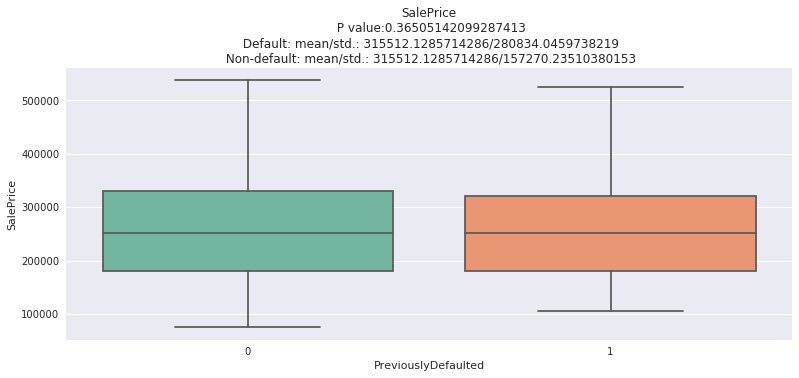

In [7]:
from scipy.stats import chi2_contingency,ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sub_yes = loan[loan["PreviouslyDefaulted"] == 1]
sub_no = loan[loan["PreviouslyDefaulted"] == 0]

p_value = ttest_ind(sub_yes['SalePrice'], sub_no["SalePrice"], equal_var = False)[1]
    
fig, axs = plt.subplots(nrows= 1, figsize=(13, 5))
sns.boxplot(x = "PreviouslyDefaulted", y = "SalePrice", data = loan, showfliers=False, palette="Set2")
if p_value < .05:
    plt.title("SalePrice" + "\n P value:" + str(p_value) + "\n The distributions for the two groups are significantly different!" + "\n Default: mean/std.: " + str(sub_yes["SalePrice"].describe()[1]) + "/" + str(sub_yes["SalePrice"].describe()[2]) + "\n Non-default: mean/std.: " + str(sub_no["SalePrice"].describe()[1]) + "/" + str(sub_no["SalePrice"].describe()[2]))
else:
    plt.title("SalePrice" + "\n P value:" + str(p_value) + "\n Default: mean/std.: " + str(sub_yes["SalePrice"].describe()[1]) + "/" + str(sub_yes["SalePrice"].describe()[2]) + "\n Non-default: mean/std.: " + str(sub_yes["SalePrice"].describe()[1]) + "/" + str(sub_no["SalePrice"].describe()[2]))

### Loan Amount as a model feature?

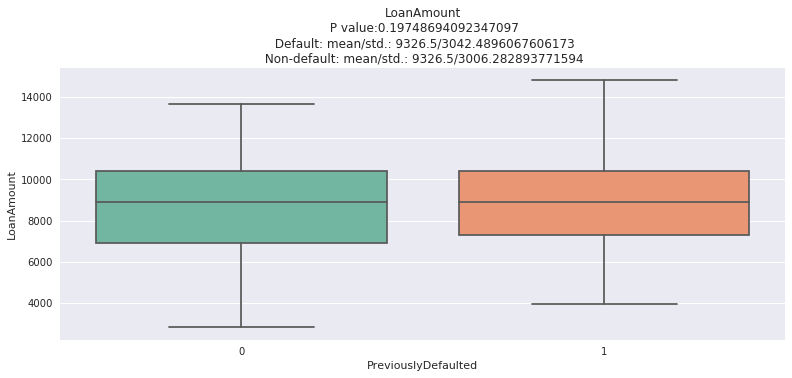

In [8]:
from scipy.stats import chi2_contingency,ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sub_yes = loan[loan["PreviouslyDefaulted"] == 1]
sub_no = loan[loan["PreviouslyDefaulted"] == 0]

p_value = ttest_ind(sub_yes['LoanAmount'], sub_no["LoanAmount"], equal_var = False)[1]
    
fig, axs = plt.subplots(nrows= 1, figsize=(13, 5))
sns.boxplot(x = "PreviouslyDefaulted", y = "LoanAmount", data = loan, showfliers=False, palette="Set2")
if p_value < .05:
    plt.title("LoanAmount" + "\n P value:" + str(p_value) + "\n The distributions for the two groups are significantly different!" + "\n Default: mean/std.: " + str(sub_yes["LoanAmount"].describe()[1]) + "/" + str(sub_yes["LoanAmount"].describe()[2]) + "\n Non-default: mean/std.: " + str(sub_no["LoanAmount"].describe()[1]) + "/" + str(sub_no["LoanAmount"].describe()[2]))
else:
    plt.title("LoanAmount" + "\n P value:" + str(p_value) + "\n Default: mean/std.: " + str(sub_yes["LoanAmount"].describe()[1]) + "/" + str(sub_yes["LoanAmount"].describe()[2]) + "\n Non-default: mean/std.: " + str(sub_yes["LoanAmount"].describe()[1]) + "/" + str(sub_no["LoanAmount"].describe()[2]))

### Data field correlation

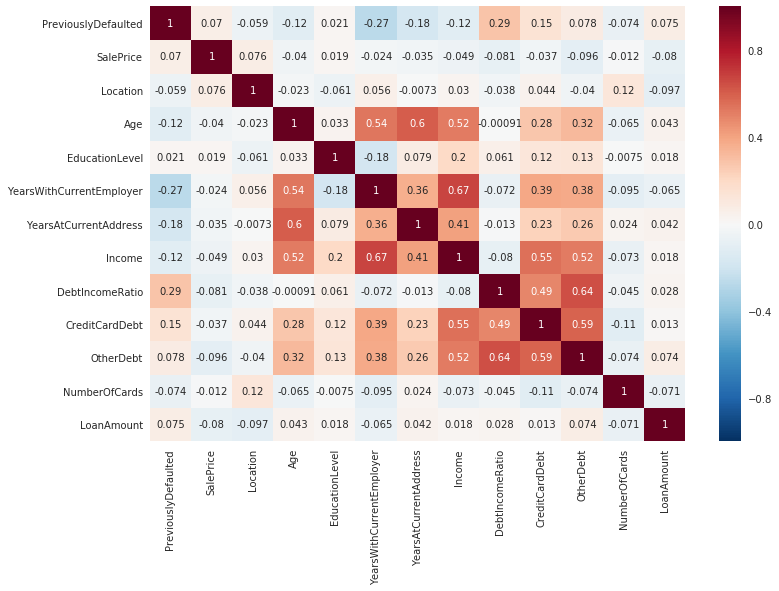

In [9]:
plt.figure(figsize=(12, 8))

corr_df = loan.iloc[:,1:].corr()

sns.heatmap(corr_df, 
            xticklabels = corr_df.columns.values,
            yticklabels = corr_df.columns.values,
            annot = True);

## Data preparation

In [10]:
# remove non-feature columns  
loan = loan.drop(['ID','City','SalePrice','Residence','LoanAmount','Location','NumberOfCards'], axis=1)

In [ ]:
# display data types
loan.dtypes

In [ ]:
# display data types
loan.dtypes

In [ ]:
# Convert the predictor type to Float to facilitate matrix multiplication with weights and biases within the neural network.
cols = ['Age','EducationLevel','YearsWithCurrentEmployer','YearsAtCurrentAddress','Income']
loan[cols] = loan[cols].applymap(np.float)

In [ ]:
# data types after the conversion
loan.dtypes

<a id="modelling"></a>
## Keras Sequential Modelling

We will fit a **Keras Sequential model**. We will use the Keras framework as a front end, and use the Tensorflow library as a backend.

In [ ]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(loan[['Age','EducationLevel','YearsWithCurrentEmployer','YearsAtCurrentAddress','Income','DebtIncomeRatio','CreditCardDebt','OtherDebt']],loan['PreviouslyDefaulted'])

In [ ]:
model = Sequential([
    Dense(12, input_dim=8, activation='relu'),
    Dense(8, activation='relu'),
    Dense(2, activation='softmax'),
])

In [ ]:
model.summary()

The model has 3 layers in the neural network. The first layer requires an input_dim parameter, which denotes the number of input features. The final layer uses the softmax function, which is used primarily in categorical predictions. We also denote that we are looking for 2 categories of default status (0 and 1)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

The above cell denotes that we will be using the **adam optimizer**, a fairly well-known and efficient optimizer, along with the **categorical_crossentropy loss**, as we are predicted a binary class output. We will use the accuracy score metric to evaluate how our model performs during each training epoch.

In [ ]:
y_classes = keras.utils.to_categorical(y_train, num_classes=2)

The above cell converts our single column output vector into a 2 column vector, one column for each predicted output. This will allow Keras to assign predicted probabilities to each class, ultimately selected the most probable class for its prediction.

In [ ]:
model.fit(X_train.values,y_classes, epochs=99, batch_size=1000, verbose=0)
model.fit(X_train.values,y_classes, epochs=1, batch_size=1000, verbose=2)

<a id="evaluation"></a>
## Model Evaluation

We run a few evaluation metrics on our model using the accuracy_score and confusion_matrix metrics

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
# predict on X_Test
y_pred = model.predict(X_test.as_matrix())
y_pred[:5]

Recall that our y_test values just denoted the actual class. We will need to apply an **argmax** function to our predicted values to determine the most probable class

In [ ]:
predicted_classes = pd.DataFrame(y_pred).apply(np.argmax, axis=1)
predicted_classes.values

In [ ]:
# compare 2 arrays
accuracy_score(y_test,predicted_classes)

In [ ]:
confusion_matrix(y_test, predicted_classes)

<a id="Save"></a>
## Save Model to DSX Filesystem

In [ ]:
from dsx_ml.ml import save

In [ ]:
save(model = model,
     name = 'MortgageDefault_Model',
     x_test = X_test,
     y_test = pd.DataFrame(y_test),
     algorithm_type = 'Classification')

In [ ]:
# Write the test data to a .csv so that we can later use it for Evaluation
#writeCSV = pd.concat([X_test, y_test], axis=1, join='inner')
#writeCSV.to_csv('../datasets/MortgageDefaultModelEval.csv', sep=',', index=False)

### Model Metadata

In [ ]:
import json
import os

proj_dir = os.environ['DSX_PROJECT_DIR']

with open('{}/models/MortgageDefault_Model/metadata.json'.format(proj_dir),'r') as infile:
    metadata_dict = json.load(infile)

print("Runtime: {}".format(metadata_dict['runtime']))
print("Model Type: {}".format(metadata_dict['type']))
print("Algorithm: {}".format(metadata_dict['algorithm']))

print("Feature(s):")
for feature in metadata_dict['features']:
    print('    '+feature['name'])

print("Latest Model Version: {}".format(metadata_dict['latestModelVersion']))
print("Label(s):")
for label in metadata_dict['labelColumns']:
    print('    '+label['name'])

<a id='Summary'></a>
## Summary
In this notebook you learned how to create a `Keras` model, evaluate the model numerically and graphically, and save the model in the DSX local environment.

In [ ]:
%%javascript
Jupyter.notebook.session.delete();

<hr>
Copyright © IBM Corp. 2018. This notebook and its source code are released under
the terms of the MIT License.